# Imports

In [1]:
import os
import re
import pandas as pd
import numpy as np
from natsort import natsorted
from scipy.integrate import simpson
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear
from py_wake.flow_map import Points

from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum
from py_wake.superposition_models import WeightedSum

# Turbines and site

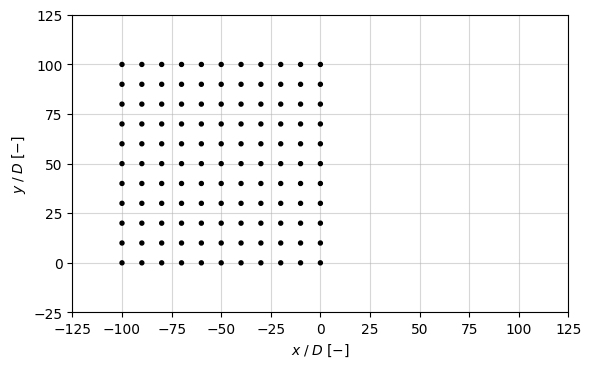

In [2]:
# --- Turbine definition ---
po = [0, 0, 0, 0, 0, 0, 0, 49, 97, 183, 268, 369, 470, 580, 722, 
      900, 1103, 1315, 1526, 1705, 1883, 1940, 1980, 1995, 2000, 
      2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 
      2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
ct = 0.8 * np.ones_like(po)
u = np.linspace(0, len(po), len(po))

turbine = WindTurbine(name='Turbines',
                      diameter=100,
                      hub_height=100,
                      powerCtFunction=PowerCtTabular(u, po, 'kW', ct))

site = UniformSite(shear=PowerShear(h_ref=turbine.hub_height(), alpha=0.1))

# --- Farm and spacing settings ---
farm_width = 10000  # meters
farm_height = 10000  # meters
D = turbine.diameter()
s = 10 * D  # turbine spacing

# Automatically compute number of rows/columns
n_cols = int(np.floor(farm_width / s)) + 1
n_rows = int(np.floor(farm_height / s)) + 1

# Generate turbine grid
x_grid, y_grid = np.meshgrid(np.arange(n_cols) * s,
                             np.arange(n_rows) * s)

x = x_grid.ravel()
y = y_grid.ravel()

# Rotate turbines if needed
theta_deg = 0
theta_rad = -np.radians(theta_deg)

rotation_matrix = np.array([
    [np.cos(theta_rad), -np.sin(theta_rad)],
    [np.sin(theta_rad),  np.cos(theta_rad)]
])

xy_rotated = rotation_matrix @ np.vstack([x, y])
x, y = xy_rotated[0], xy_rotated[1]

# Normalize origin
x = x - np.max(x)  # x=0 at downstream edge
y = y - np.min(y)  # y=0 at lowest turbine

# --- Plot ---
padding = 25  # [D]

fig, ax = plt.subplots()

for x_t, y_t in zip(x, y):
    circle = Circle((x_t/D, y_t/D), 1, color='black', fill=True)
    ax.add_patch(circle)

ax.set_xlim(min(x)/D - padding, max(x)/D + 5*padding)
ax.set_ylim(min(y)/D - padding, max(y)/D + padding)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

tick_interval = 25  # [D]
xticks = np.arange(-1000, 1000, tick_interval)
yticks = np.arange(-1000, 1000, tick_interval)

xticks = xticks[(xticks >= xlim[0]) & (xticks <= xlim[1])]
yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xlabel(r"$x \; / \; D \; [-]$")
ax.set_ylabel(r"$y \; / \; D \; [-]$")
ax.set_aspect('equal')
ax.grid(True, alpha=0.5)
ax.set_axisbelow(True)
plt.show()

# Flow map

In [3]:
wdir = 270  # [deg]
U_0 = 10  # [m/s]
ti = 0.1

mpl.rcParams.update(mpl.rcParamsDefault)
#fig, ax = plt.subplots(figsize=(10, 6))

wfm = PropagateDownwind(site, turbine,
                        wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                        superpositionModel=WeightedSum())
sim = wfm(x, y, ws=U_0, wd=wdir, TI=ti)

#sim.flow_map().plot_wake_map(ax=ax, normalize_with=D, plot_windturbines=False)
'''
for x_t, y_t in zip(x, y):
    circle = Circle((x_t/D, y_t/D), radius=1, color='black', fill=True)
    ax.add_patch(circle)
    
ax.set_xlabel(r"$x \; [m]$")
ax.set_ylabel(r"$y \; [m]$")
ax.set_aspect('equal')
ax.grid(True)
plt.tight_layout()
plt.show()
'''

<>:19: SyntaxWarning: invalid escape sequence '\;'
<>:19: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_17564/4121737635.py:19: SyntaxWarning: invalid escape sequence '\;'
  ax.set_xlabel(r"$x \; [m]$")


'\nfor x_t, y_t in zip(x, y):\n    circle = Circle((x_t/D, y_t/D), radius=1, color=\'black\', fill=True)\n    ax.add_patch(circle)\n\nax.set_xlabel(r"$x \\; [m]$")\nax.set_ylabel(r"$y \\; [m]$")\nax.set_aspect(\'equal\')\nax.grid(True)\nplt.tight_layout()\nplt.show()\n'

# Load TDM data

In [4]:
validation_data_path = "../ArbitraryLayouts/ValidationData"

# List only files, sorted alphabetically
validation_files = natsorted(
    [f for f in os.listdir(validation_data_path) if os.path.isfile(os.path.join(validation_data_path, f))]
)

validation_datasets = {}
for file in validation_files:
    if file.endswith('.csv'):
        file_path = os.path.join(validation_data_path, file)
        validation_datasets[file] = pd.read_csv(file_path)

print("Loaded datasets:", list(validation_datasets.keys()))

Loaded datasets: ['400D.csv', '600D.csv', '800D.csv']


# Wind speed profiles

----- 400 D -----
kx: 0.09145  [m/m]
k:  3658     [m]

----- 600 D -----
kx: 0.06928  [m/m]
k:  4157     [m]

----- 800 D -----
kx: 0.05637  [m/m]
k:  4509     [m]



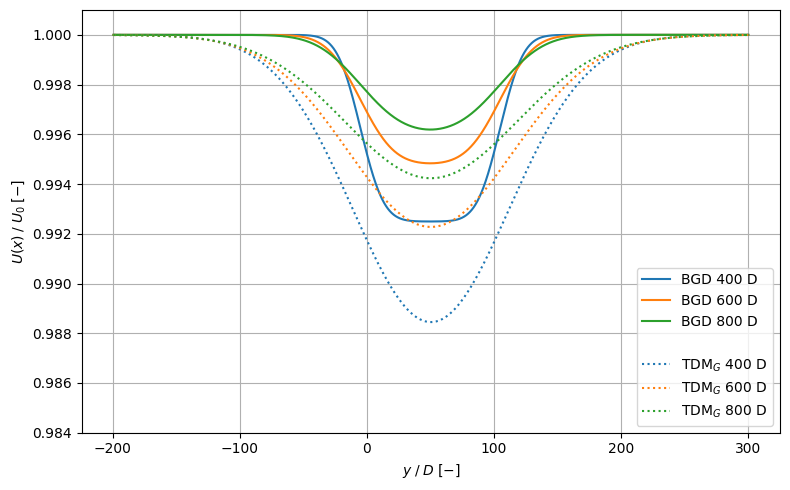

In [5]:
d_downstream = [400, 600, 800]
plot_width = 500  # in D

# Calculate number of points to match the desired spanwise resolution
y_agreed = int(plot_width * D)
y_range = None  # Will be defined once center is determined

ws_meas = {}
padded_tdm = {}
U_gauss = {}
U_gaussA = {}
tdm_lengths = {}
ftg_profiles = {}
ftg_n_solutions = {}
gauss_profiles = {}

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel(r'$y \; / \; D \; [-]$')
ax.set_ylabel(r'$ U(x) \; / \; U_0 \; [-] $')
ax.grid(True)

# --- TDM profiles (prepare first to get centering right) ---
centers = {}
for file in validation_files:
    match = re.search(r'(\d+)', file)
    d = int(match.group(1)) if match else None

    tdm_data = validation_datasets[file]
    y_col = tdm_data.iloc[:, 0].values * D  # convert from D to meters
    center = (y_col[0] + y_col[-1]) / 2
    centers[d] = center

# Define common y_range centered around each file’s true center
# We'll assume the center for the first valid distance in `d_downstream`
center_base = centers.get(d_downstream[0], 0)
y_range = np.linspace(-plot_width / 2 * D, plot_width / 2 * D, y_agreed) + center_base

# --- PyWake profiles ---
for d in d_downstream:
    m = d * D
    x_meas = np.full(y_range.shape, max(x) + m)

    ws_meas[d] = np.squeeze(
        sim.flow_map(Points(
            x=x_meas,
            y=y_range,
            h=turbine.hub_height() * np.ones_like(y_range)
        )).WS_eff.values)

    ax.plot(y_range / D, ws_meas[d] / U_0, label=f'BGD {d} D')

ax.plot([], [], linestyle='None', marker='', label=' ')

# --- TDM profiles ---
for i, file in enumerate(validation_files):
    match = re.search(r'(\d+)', file)
    d = int(match.group(1)) if match else None

    tdm_data = validation_datasets[file]
    y_col = tdm_data.iloc[:, 0].values * D
    tdm_values = tdm_data.iloc[:, 1].values

    if d is not None:
        tdm_lengths[d] = len(tdm_values)

        # Center the data around the shared y_range
        center = centers[d]
        y_offset = y_range - center

        # Interpolate original data to fit common y_range
        tdm_interp = np.interp(y_range, y_col, tdm_values, left=U_0 / 10, right=U_0 / 10)
        padded_tdm[d] = tdm_interp

        #color = ax.get_lines()[i].get_color()
        #ax.plot(y_range / D, padded_tdm[d], linestyle='--', label=f'TDM {d} D')

#ax.plot([], [], linestyle='None', marker='', label=' ')

# --- Gauss ---
rho = 1.225

for i, (d, file) in enumerate(zip(d_downstream, validation_files)):
    
    tdm_data = validation_datasets[file]
    kx = tdm_data.iloc[:, -1].values[0]

    print(f'----- {d} D -----')
    print(f'kx: {kx:.5f}  [m/m]')
    k = kx * d*D
    print(f'k:  {k:.0f}     [m]\n')

    U_TDM = padded_tdm[d] * U_0
    M_TDM = rho * simpson((U_0 - U_TDM)**2, x=y_range)

    sigma = (tdm_lengths[d]) / (2 * np.sqrt(2))

    A = np.sqrt(M_TDM / (rho * sigma * np.sqrt(np.pi)))

    U_gauss[d] = U_0 - A * np.exp(- (y_range - centers[d])**2 / (2*sigma**2))
    M_Gau = rho * simpson((U_0 - U_gauss[d])**2, x=y_range)
    
    color = ax.get_lines()[i].get_color()
    ax.plot(y_range / D, U_gauss[d] / U_0, linestyle=':', color=color, label=fr'TDM$_G$ {d} D')

ax.legend(loc='lower right')
plt.ylim(0.984, 1.001)
plt.tight_layout()
plt.show()

# Momentum comparison

In [6]:
rho = 1.225

col_width = 10  # adjust this to control column width

for d in d_downstream:
    print(f"\n{f' {d} D ':=^{col_width * 3}}")

    # Hastigheder
    U_PyW = ws_meas[d]
    U_TDM = U_gauss[d]

    # Momentum
    M_PyW = rho * simpson(U_PyW**2, x=y_range)
    M_TDM = rho * simpson(U_TDM**2, x=y_range)

    # Momentumtab
    M_def_PyW = rho * simpson((U_0 - U_PyW)**2, x=y_range)
    M_def_TDM = rho * simpson((U_0 - U_TDM)**2, x=y_range)

    # Procent forskel
    M_dev = 100 * (M_TDM - M_PyW) / M_PyW
    M_def_dev = 100 * (M_def_TDM - M_def_PyW) / M_def_PyW

    # Max forskel i hastighed
    U_dev = 100 * (np.min(U_TDM) - np.min(U_PyW)) / np.min(U_PyW)

    # Print table rows
    print(f"{'M_PyW':<{col_width}} | {M_PyW:{col_width}.0f} | {'kg·m/s²':<{col_width}}")
    print(f"{'M_TDM':<{col_width}} | {M_TDM:{col_width}.0f} | {'kg·m/s²':<{col_width}}")
    print(f"{'M_dev':<{col_width}} | {M_dev:+{col_width}.2f} | {'%':<{col_width}}\n")

    print(f"{'M_def_PyW':<{col_width}} | {M_def_PyW:{col_width}.2f} | {'kg·m/s²':<{col_width}}")
    print(f"{'M_def_TDM':<{col_width}} | {M_def_TDM:{col_width}.2f} | {'kg·m/s²':<{col_width}}")
    print(f"{'M_def_dev':<{col_width}} | {M_def_dev:+{col_width}.2f} | {'%':<{col_width}}\n")

    print(f"{'U_dev':<{col_width}} | {U_dev:+{col_width}.2f} | {'%':<{col_width}}")


=========== 400 D ============
M_PyW      |    6104834 | kg·m/s²   
M_TDM      |    6081499 | kg·m/s²   
M_dev      |      -0.38 | %         

M_def_PyW  |      64.58 | kg·m/s²   
M_def_TDM  |     178.39 | kg·m/s²   
M_def_dev  |    +176.22 | %         

U_dev      |      -0.41 | %         

=========== 600 D ============
M_PyW      |    6110971 | kg·m/s²   
M_TDM      |    6094210 | kg·m/s²   
M_dev      |      -0.27 | %         

M_def_PyW  |      28.70 | kg·m/s²   
M_def_TDM  |      84.32 | kg·m/s²   
M_def_dev  |    +193.76 | %         

U_dev      |      -0.26 | %         

=========== 800 D ============
M_PyW      |    6114240 | kg·m/s²   
M_TDM      |    6101121 | kg·m/s²   
M_dev      |      -0.21 | %         

M_def_PyW  |      15.43 | kg·m/s²   
M_def_TDM  |      48.78 | kg·m/s²   
M_def_dev  |    +216.18 | %         

U_dev      |      -0.20 | %         


# Momentum

In [7]:
for d, file in zip(d_downstream, validation_files):

    tdm_data = validation_datasets[file]
    k = tdm_data.iloc[:, -1].values[0]

    U_PyW = ws_meas[d]
    M_PyW = rho * simpson((U_0 - U_PyW)**2, x=y_range)

    U_TDM = padded_tdm[d] * U_0
    M_TDM = rho * simpson((U_0 - U_TDM)**2, x=y_range)

    U_Gau = U_gauss[d]
    M_Gau = rho * simpson((U_0 - U_Gau)**2, x=y_range)

    print('\nM_PyW:', round(M_PyW,2))
    #print('M_TDM:', M_TDM)
    print('M_Gau:', round(M_Gau,2))
    print(f'k({d}): {k:.0e}')


M_PyW: 64.58
M_Gau: 178.39
k(400): 9e-02

M_PyW: 28.7
M_Gau: 84.32
k(600): 7e-02

M_PyW: 15.43
M_Gau: 48.78
k(800): 6e-02


# Forhold mellem maks og gns. hastighed (PyWake)

In [8]:
def_mean_mean = 0

for d in d_downstream:

    def_mean = np.mean(U_0-ws_meas[d])
    def_max = np.max(U_0-ws_meas[d])

    print('\nU_def_gns:', def_mean)
    print('U_def_min:', def_max)
    print('max/mean:', def_max / def_mean)

    def_mean_mean +=  def_max / def_mean

def_mean_mean = def_mean_mean/3
print('\ndef_mean_mean:', def_mean_mean)


U_def_gns: 0.016514079266926125
U_def_min: 0.07504719269194382
max/mean: 4.544436990940571

U_def_gns: 0.011475208291199974
U_def_min: 0.05165298720427636
max/mean: 4.501267941592627

U_def_gns: 0.008795797609383961
U_def_min: 0.03808612145551926
max/mean: 4.330036131673422

def_mean_mean: 4.45858035473554
